Mean Squared Error: 25793.101295386434


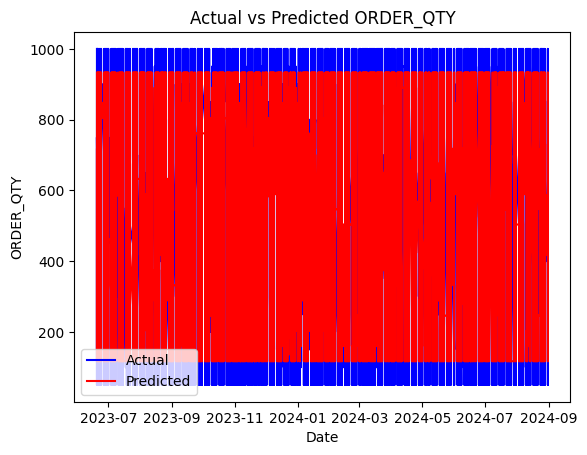

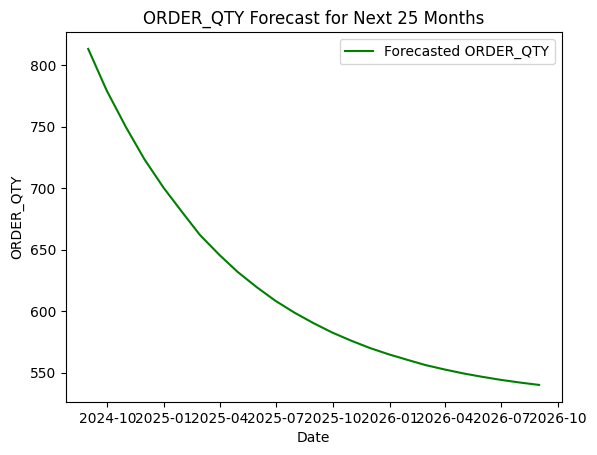

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your dataset
# Assuming 'df' is the DataFrame that contains your data
# df = pd.read_csv('your_data.csv')
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()
 
table_name = '"MASTER_DATA"'
 
sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()
# Convert 'ORDER_DATE' to datetime
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

# Sort data by 'ORDER_DATE' to maintain time series order
df = df.sort_values(by='ORDER_DATE')

# Create new columns for lag features (e.g., Lag1, Lag2, etc.)
df['Lag1'] = df['ORDER_QTY'].shift(1)
df['Lag2'] = df['ORDER_QTY'].shift(2)

# Drop rows with NaN values (due to shifting)
df = df.dropna()

# Define the features (Lag1, Lag2, etc.) and target (ORDER_QTY)
X = df[['Lag1', 'Lag2']]
y = df['ORDER_QTY']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot actual vs predicted for the test set
plt.plot(df['ORDER_DATE'].iloc[len(X_train):], y_test, label='Actual', color='blue')
plt.plot(df['ORDER_DATE'].iloc[len(X_train):], y_pred, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('ORDER_QTY')
plt.title('Actual vs Predicted ORDER_QTY')
plt.legend()
plt.show()

# Forecast for the next 25 months
# Create a new DataFrame for future dates
future_dates = pd.date_range(df['ORDER_DATE'].max(), periods=25, freq='M')

# Initialize the last known values for lag features
last_lag1 = df['ORDER_QTY'].iloc[-1]
last_lag2 = df['Lag1'].iloc[-1]

# Create an empty list to store predictions
future_preds = []

for i in range(25):
    # Prepare input features for the next prediction
    future_X = np.array([[last_lag1, last_lag2]])
    
    # Predict the next ORDER_QTY
    future_pred = model.predict(future_X)[0]
    
    # Append the prediction to the list
    future_preds.append(future_pred)
    
    # Update lag values for the next iteration
    last_lag2 = last_lag1
    last_lag1 = future_pred

# Plot future predictions
plt.plot(future_dates, future_preds, label='Forecasted ORDER_QTY', color='green')
plt.xlabel('Date')
plt.ylabel('ORDER_QTY')
plt.title('ORDER_QTY Forecast for Next 25 Months')
plt.legend()
plt.show()